<a href="https://colab.research.google.com/github/Kontrabass2018/DeepLearningGPU/blob/main/Deep_Learning_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-12-12 04:34:48 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# First Installation

## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, skylake-avx512)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_NUM_THREADS = 2


## Installation and importation of useful libraries
In this section we will use the Flux library and this the link to the  [official Julia Flux documentation](https://fluxml.ai/Flux.jl).

We will also use the CUDA package [link to the official Julia CUDA documentation](https://cuda.juliagpu.org/stable/).

In [2]:
# only first time!
using Pkg
#Pkg.add("CUDA")
Pkg.add("Flux")
Pkg.add("HDF5")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed RealDot ──────────────── v0.1.0
   Installed DiffRules ────────────── v1.15.1
   Installed GPUArraysCore ────────── v0.1.5
   Installed IRTools ──────────────── v0.4.14
   Installed IrrationalConstants ──── v0.2.2
   Installed Transducers ──────────── v0.4.84
   Installed ContextVariablesX ────── v0.1.3
   Installed ShowCases ────────────── v0.1.0
   Installed ArgCheck ─────────────── v2.4.0
   Installed Accessors ────────────── v0.1.39
   Installed FLoopsBase ───────────── v0.1.1
   Installed DiffResults ──────────── v1.1.0
   Installed Adapt ────────────────── v3.7.2
   Installed SpecialFunctions ─────── v2.5.0
   Installed Functors ─────────────── v0.4.12
   Installed PtrArrays ────────────── v1.2.1
   Installed ProgressLogging ──────── v0.1.4
   Installed NNlib ────────────────── v0.8.21
   Installed Flux ─────────────────── v0.13.17
   Installed cuDNN ────────────────── v1.1.1

In [1]:
using CUDA
using Flux
using HDF5

## Importing Data

In [2]:
using Random
function load_tcga_data(infilename; shfl = true)
    infile = h5open(infilename)
    TCGA_data = infile["data"][:,:]
    labs = string.(infile["labels"][:])
    samples = string.(infile["samples"][:])
    genes = string.(infile["genes"][:])
    biotypes = string.(infile["biotypes"][:])
    close(infile)
    ids = collect(1:size(labs)[1])
    shfl && (ids = shuffle(ids))
    return TCGA_data[ids,:], labs[ids], samples[ids], genes, biotypes
end

function fetch_data(filename; shfl = true)
    if !(filename in readdir("."))
        # Define the URL`
        tcga_data_url = "https://bioinfo.iric.ca/~sauves/VARIA/$filename"

        # Escape the URL to handle special characters
        escaped_url = Base.shell_escape(tcga_data_url)

        # Construct and execute the wget command
        command = `wget $escaped_url`
        run(command)
    end
    load_tcga_data(filename; shfl = shfl)

end

fetch_data (generic function with 1 method)

In [3]:
infilename = "TCGA_19962_TPM_lab.h5"
TCGA_data, labels, samples, genes, biotypes = fetch_data(infilename);

# Installing the DNN architecture

In [7]:
Pkg.add(url="https://github.com/Kontrabass2018/FactorizedEmbeddings")

     Cloning git-repo `https://github.com/Kontrabass2018/FactorizedEmbeddings`
    Updating git-repo `https://github.com/Kontrabass2018/FactorizedEmbeddings`
   Resolving package versions...
   Installed ProgressMeter ─ v1.10.2
    Updating `~/.julia/environments/v1.8/Project.toml`
  [88092329] + FactorizedEmbeddings v0.1.0 `https://github.com/Kontrabass2018/FactorizedEmbeddings#main`
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [88092329] + FactorizedEmbeddings v0.1.0 `https://github.com/Kontrabass2018/FactorizedEmbeddings#main`
  [92933f4c] + ProgressMeter v1.10.2
Precompiling project...
  ✓ ProgressMeter
  ✓ FactorizedEmbeddings
  2 dependencies successfully precompiled in 13 seconds. 126 already precompiled.


In [4]:
using FactorizedEmbeddings

# Training a Factorized Embeddings model with the input data to GPU

In [5]:
redux_data = fit_transform(TCGA_data, verbose =1, nsteps=40_000)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Progress: 100%|███████████████████████████████████████████████| Time: 0:17:38 (26.46 ms/it)
  step:     40000
  loss:     0.05642053791193962
  pearson:  0.9511623


2×10344 Matrix{Float32}:
 0.308567  -1.40089   -0.0199459  0.853801  …  -0.704754   0.044104    0.424612  -0.15686
 0.775028  -0.993997   0.474394   0.04882       0.326281  -0.0905375  -0.140531  -0.902918

## Visualizing the reduced data

### Installation of required dependencies

In [10]:
using Pkg
Pkg.add("CairoMakie")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JpegTurbo_jll ───────────── v3.0.4+0
   Installed x265_jll ────────────────── v3.6.0+0
   Installed libfdk_aac_jll ──────────── v2.0.3+0
   Installed ImageIO ─────────────────── v0.6.9
   Installed AxisArrays ──────────────── v0.4.7
   Installed TiffImages ──────────────── v0.11.2
   Installed Libmount_jll ────────────── v2.40.2+0
   Installed LERC_jll ────────────────── v4.0.0+0
   Installed JpegTurbo ───────────────── v0.1.5
   Installed StatsFuns ───────────────── v1.3.2
   Installed HypergeometricFunctions ─── v0.3.25
   Installed AdaptivePredicates ──────── v1.2.0
   Installed PNGFiles ────────────────── v0.4.3
   Installed Opus_jll ────────────────── v1.3.3+0
   Installed FFTW ────────────────────── v1.8.0
   Installed RelocatableFolders ──────── v1.0.1
   Installed Unitful ─────────────────── v1.21.1
   Installed Sixel ───────────────────── v0.1.3
   Installed Contour ──────

In [6]:
using CairoMakie

In [7]:
#Pkg.add("CSV")
#Pkg.add("DataFrames")
using CSV
using DataFrames

### Generating the plot

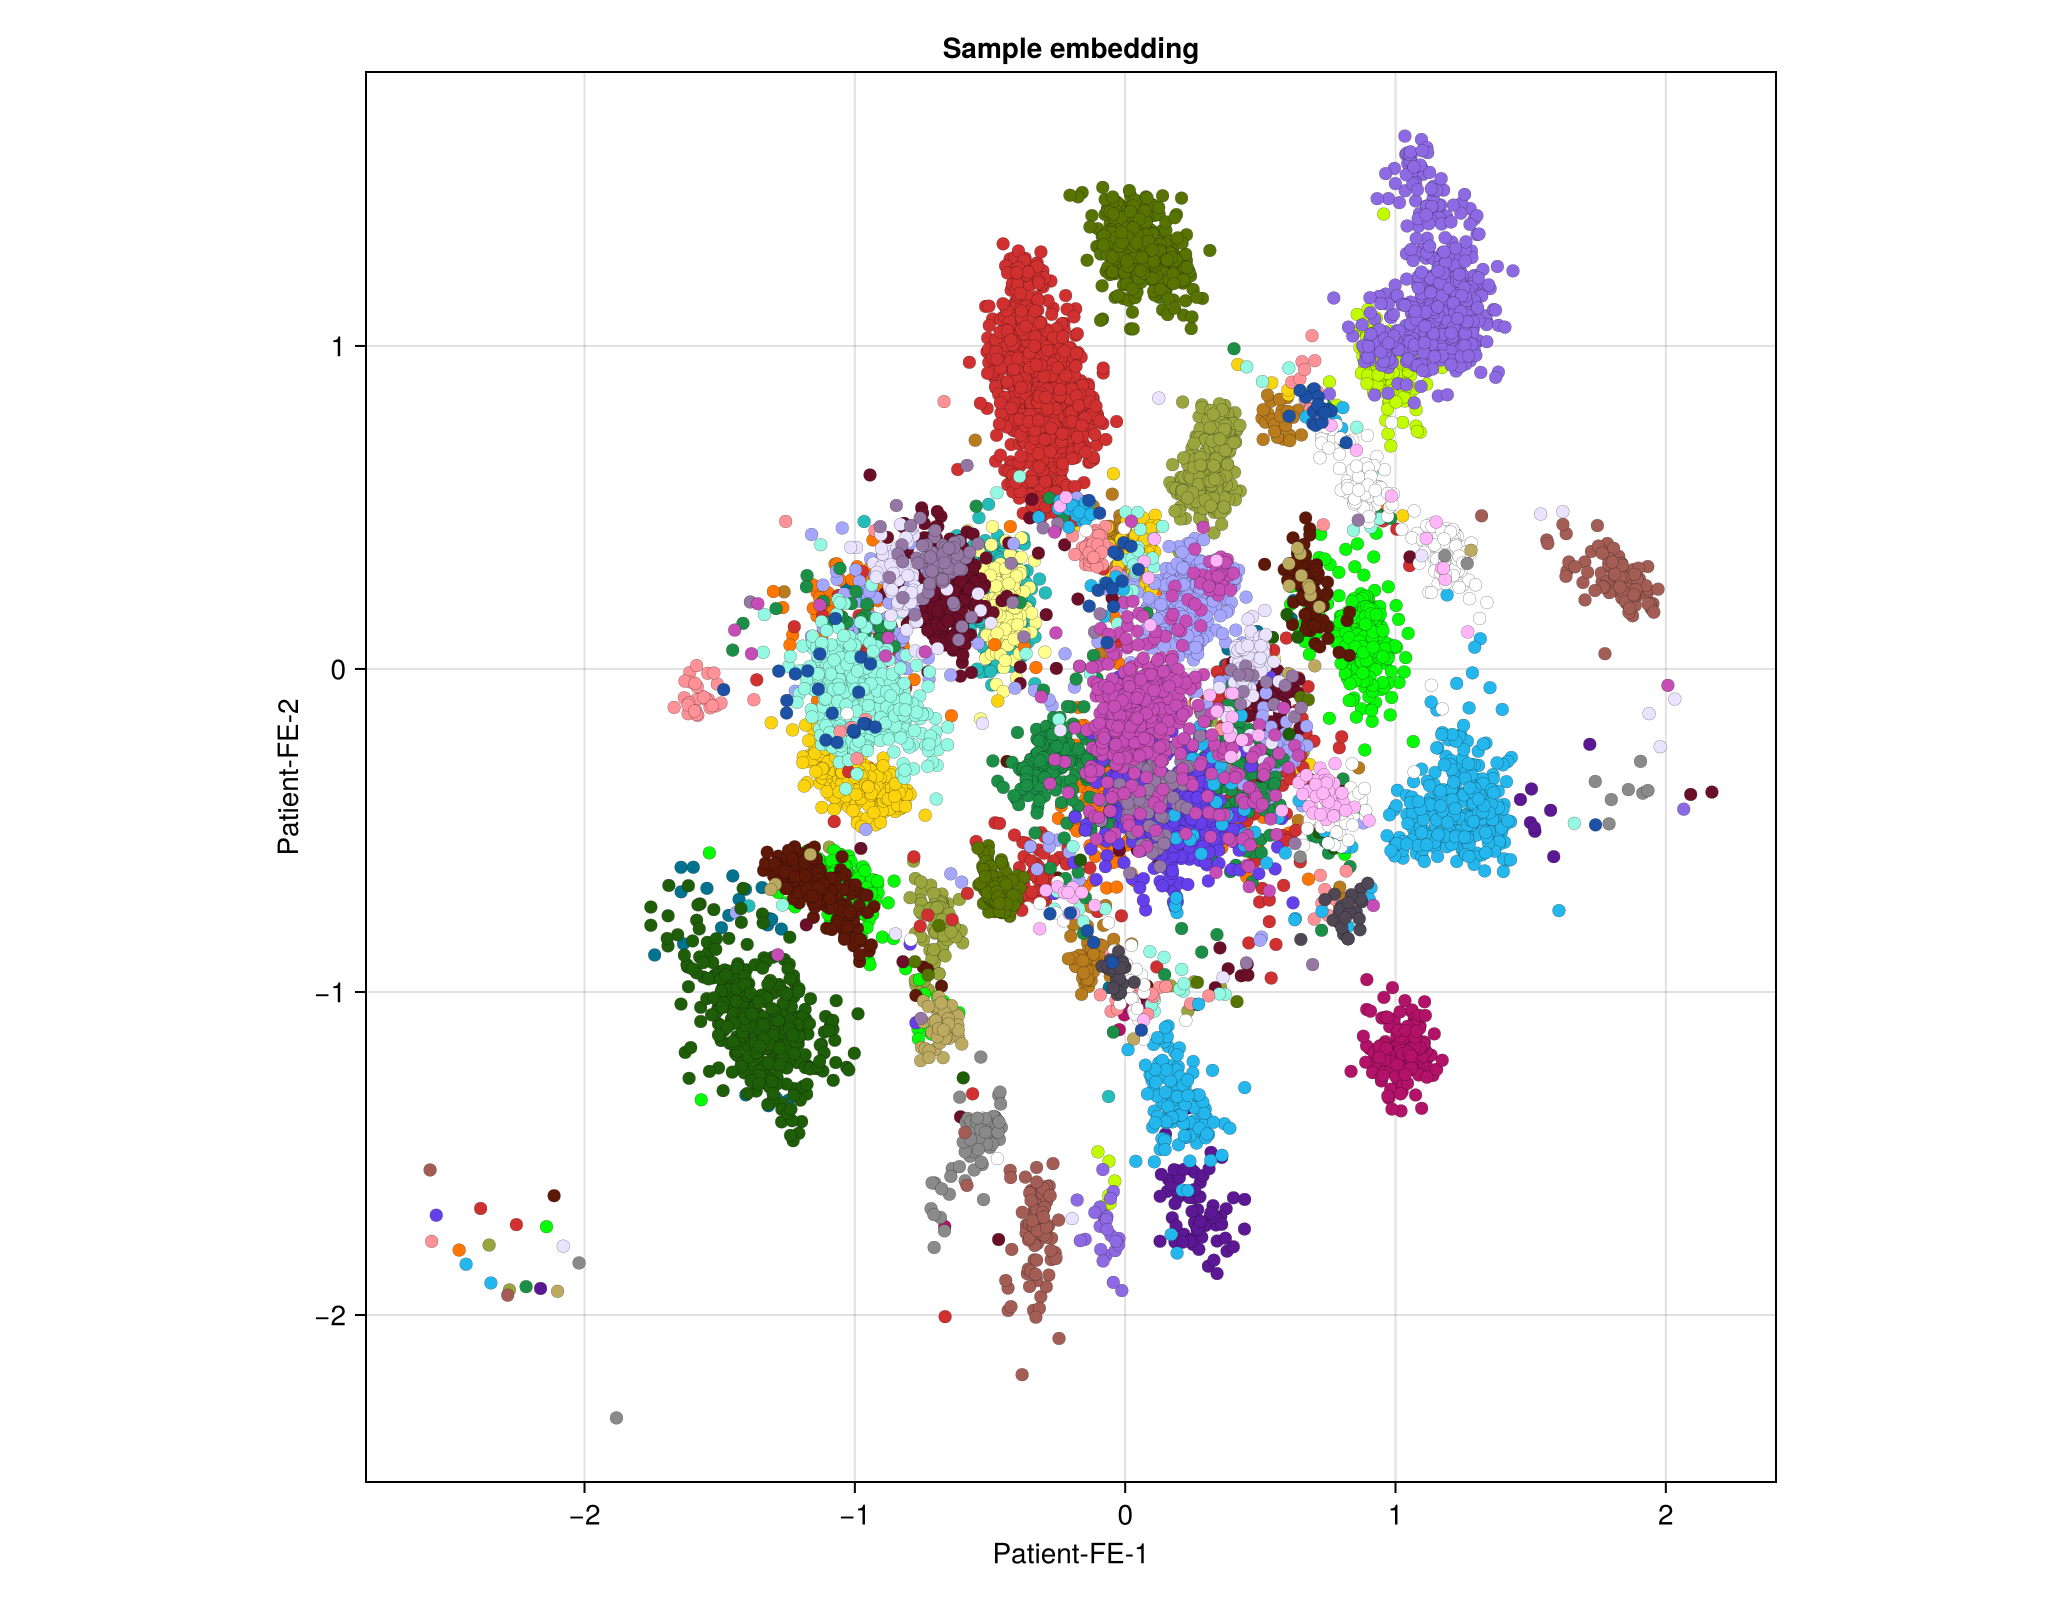

In [8]:
## get colors and definition file
TCGA_colors_file = "TCGA_colors_def.txt"
!(TCGA_colors_file in readdir(".")) && run(`wget $(Base.shell_escape("https://bioinfo.iric.ca/~sauves/VARIA/$TCGA_colors_file"))`)
## build scatter plot figure
fig = Figure(size = (1024,800));
ax = Axis(fig[1,1],title="Sample embedding", xlabel = "Patient-FE-1", ylabel="Patient-FE-2", aspect = 1);
colors_labels_df = CSV.read(TCGA_colors_file,  DataFrame)
## plot train embed with circles.
for (i, group_lab) in enumerate(unique(labels))
    group = labels .== group_lab
    col = colors_labels_df[colors_labels_df[:,"labs"] .== group_lab,"hexcolor"][1]
    name = colors_labels_df[colors_labels_df[:,"labs"] .== group_lab,"name"][1]
    scatter!(ax, redux_data[1,group], redux_data[2,group], strokewidth = 0.1, color = String(col), label = name, marker = :circle)
end
fig

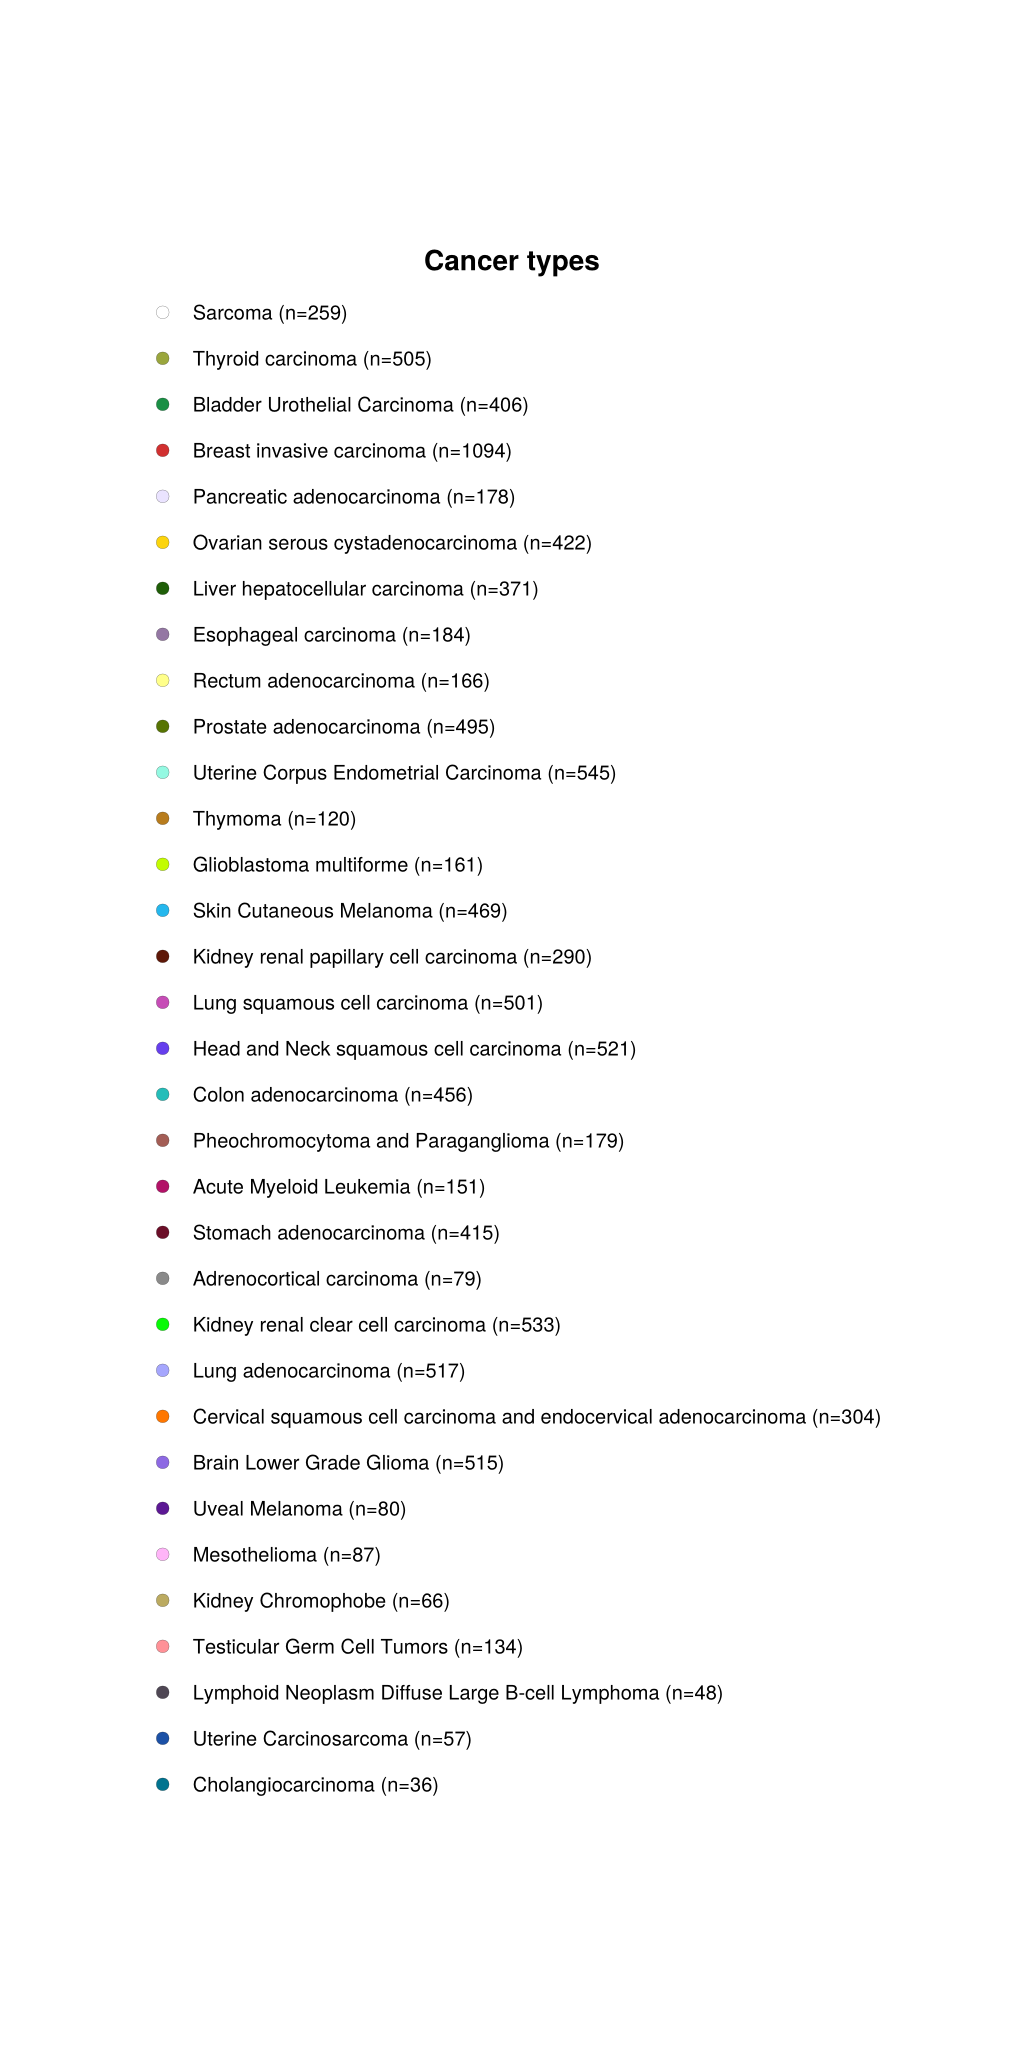

In [54]:
fig= Figure(size = (512,1024));fig[1, 1] = Legend(fig, ax, "Cancer types", labelsize = 10, framevisible = false)
fig

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />